# Esercitazione 6

In questa esercitazione l'obiettivo è completare il codice Monte Carlo adibito alla simulazione di un *modello di Ising 1D* con $50$ gradi di libertà implementando all'interno dell'algoritmo il campionamento di Metropolis e quello di Gibbs.
Una volta completata questa operazione, si chiede di stimare alcune grandezze termodinamiche del sistema con la loro incertezza statistica.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from IPython.display import HTML

In [2]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<a href="javascript:code_toggle()">Mostra/Nascondi celle</a>.''')

### Esercizio 6.1

Il modello di Ising 1D è uno dei pochi modelli della Meccanica Statistica che può essere risolto esattamente per via analitica. L'Hamiltoniana per un sistema di $N$ spin con interazione a primi vicini è data da:
$$H = -J\sum_{i=1}^N s_i s_{i+1}-\frac{h}{2}\sum_{i=1}^N (s_i + s_{i+1})$$

dove viene assunto $\mu_B=1$ e $k_B=1$ e dove $\{ s_i \}_{i=1,N}$ sono le variabili di spin che possono assumere valori $\{-1;1\}$. Viene scelto un modello di tipo ferromagnetico con condizioni periodiche al contorno per cui $J>0$ e $s_{N+1} = s_{1}$.
La funzione di partizione per un modello siffatto è la seguente: 

$$Z=\sum_{\{ s_i \}} \exp \left( -\beta H\right) = \lambda_1^N + \lambda_2^N \quad\text{dove}\quad \lambda_{1,2}=e^{\beta J}\cosh (\beta h) \pm \left[ e^{2\beta J} \cosh^2 (\beta h) - 2\sinh (2\beta J) \right]^{1/2}$$

Il sistema considerato costituisce un ensamble canonico poiché mantenuto a temperatura, numero di particelle e volume fissati. La densità di probabilità all'equilibrio $\rho$ (probabilità da campionare in fase di simulazione) per l'occupazione dei possibili stati è perciò data dalla distribuzione di Boltzmann:

$$\rho(H) = \frac{e^{-\beta H}}{Z}$$

Al fine di compiere una simulazione di tale modello viene seguita la procedura seguente:
1. Innanzitutto vengono dichiarati in modo casuale i valori iniziali dei $50$ spin che costituiscono il nostro sistema $\{s_j\}_{j=0..50}$ dove $s_j=\pm 1$;
2. Vengono implementate le condizioni periodiche al contorno, affinchè ogni spin possieda lo stesso numero di primi vicini. Inoltre in questo modo si eliminano gli effetti di bordo;
3. Viene fissata la temperatura $T$ del sistema e viene costruito lo stato iniziale $|\mu>$. Si noti che la configurazione iniziale non necessariamente coincide con lo stato di equilibrio alla temperatura $T$. E\' perciò necessario attendere un intervallo di tempo sufficiente affinchè il sistema si equilibri per andare a calcolare le medie di ensamble delle grandezze termodinamiche che ci interessano;
4. Scegliamo la probabilità di transizione $T(\nu|\mu)$ con la quale può essere "girato" un solo spin alla volta;
5. Viene determinata la probabilità di accettazione della mossa proposta al punto 4 secondo $A(\nu|\mu)$.

Se utilizziamo l'algoritmo di **Metropolis**, scegliamo $T(\nu|\mu)$ uniforme e quindi simmetrica. In questo modo la probabilità di accettazione non dipende da $T(\nu|\mu)$ e si riduce a:
$$A(\nu|\mu)=\min\bigg[1,\frac{p(\nu)}{p(\mu)}\bigg]=\min\big[1,e^{-\beta(E_{\nu} - E_{\mu})}\big]$$

Sapendo che $E_{\nu} - E_{\mu}=-J\sum_{< i,k >} s_i^{\mu}(s_k^{\nu}-s_k^{\mu})= 2Js_k^{\mu}\sum_{< i,k >} s_i^{\mu}$ allora si ha che:
1. Se $E_{\nu} - E_{\mu}<0$ allora $A(\nu|\mu)=1$, la mossa viene accettata e quindi lo spin viene girato;
2. Se $E_{\nu} - E_{\mu}>0$ allora possiamo girare il singolo spin solo con probabilità $A(\nu|\mu)=e^{-\beta(E_{\nu} - E_{\mu})}$.

Se per il campionamento usiamo l'algoritmo di **Gibbs** la mossa proposta è sempre accettata. La probabilità di avere $s_j^{\nu}$ nella nuova configurazione $|\nu \rangle$, partendo dalla configurazione $|\mu \rangle$ è:
$$p\big(s_j^{\nu}=\pm1|{s_i^{\mu}:i\neq j}\big)=\frac{1}{1+\exp{\big[\mp2\beta\big(J(s_{j-1}^{\mu}+s_{j+1}^{\mu})+h\big)}\big]}$$

Notiamo che questa probabilità viene completamente determinata dal valore dello spin delle particelle prime vicine $j-1$ e $j+1$. Proviamo a comprendere questo cosa comporta. Se assumiamo che le due particelle vicine possiedano spin concordi, all'aumentare della temperatura, la probabilità che lo spin $j$-esimo sia discorde cresce. Viceversa, al diminuire della temperatura sono favorite le configurazioni in cui lo spin $j$-esimo è concorde ai suoi primi vicini. Il risultato finale è che osservando "da lontano" il sistema, esso tende a creare raggruppamenti separati di spin concordi (naturalmente avvicinandosi al ground state i cluster tenderanno a scegliere un'unica orientazione comune).
A questo punto l'algoritmo di Gibbs inizia a generare sempre meno modifiche della configurazione globale e ciò si traduce in un impoverimento dell'insieme di configurazioni su cui effettuare le misure delle grandezze di interesse.
Come testimoniato in seguito nei grafici degli errori anche l'algoritmo di Metropolis deve fare  i conti con questa situazione e dunque troveremo gli errori a temperatura fissata paragonabili tra i due algoritmi.

---

Nell'algoritmo, dopo aver eseguito la mossa, vengono misurate alcune quantità utili al fine di rendere più semplice la successiva misurazione delle grandezze termodinamiche di interesse, quali $H$, $H^2$, $\sum_j s_j$ e $\big(\sum_j s_j\big)^2$.
A questo punto l'algoritmo calcola i valori di aspettazione delle grandezze che ci interessano attraverso le seguenti relazioni (assunto $k_B=1$):
$$U(N,T) = \langle H \rangle_{h=0}$$

$$C(N,T) = \frac{\partial U(N,T)}{\partial T}\bigg|_{h=0} = \beta^2 \big(\langle H^2 \rangle_{h=0}-\langle H \rangle_{h=0}^2\big)$$

$$\chi(N,T) =  \frac{\partial M}{\partial h}\bigg|_{h=0} = \beta \bigg\langle \big(\sum_{i=1,N}s_i\big)^2 \bigg\rangle_{h=0}$$

Naturalmente ci aspettiamo che per nessuna temperatura finita il sistema si magnetizza spontaneamente, perciò al fine di misurare la magnetizzazione $M$ accendiamo il campo esterno $h$:

$$M(N,T,h=0.02)= T \frac{\partial \ln Z}{\partial h}\bigg|_{h=0.02} = \bigg\langle \sum_{i=1,N}s_i \bigg\rangle_{h=0.02}$$


Per prima cosa ci occupiamo dell'equilibrazione del sistema. Analizziamo a tal fine l'andamento dell'energia interna per particella (ad esempio) in funzione del numero di blocchi.

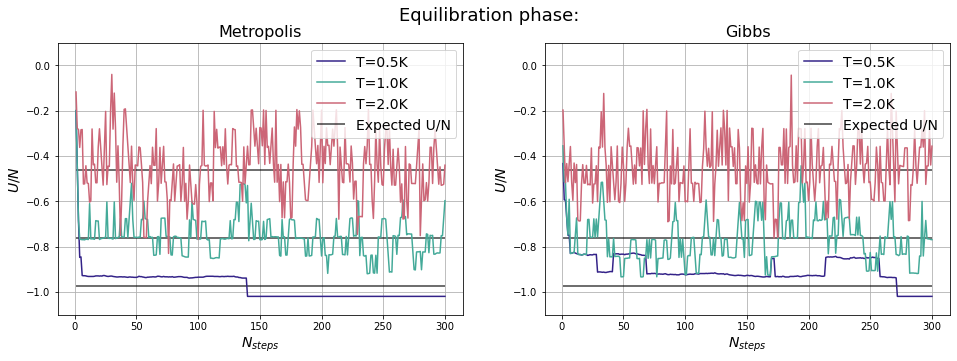

In [4]:
x_blocks = np.arange(1,301,1)
data_eq_metro = np.loadtxt('equilibration_en_metro_0.500000.dat')
data_eq_gibbs = np.loadtxt('equilibration_en_gibbs_0.500000.dat')
data_eq_metro1 = np.loadtxt('equilibration_en_metro_1.000000.dat')
data_eq_gibbs1 = np.loadtxt('equilibration_en_gibbs_1.000000.dat')
data_eq_metro2 = np.loadtxt('equilibration_en_metro_2.000000.dat')
data_eq_gibbs2 = np.loadtxt('equilibration_en_gibbs_2.000000.dat')

J = 1.0
Ns = 50

T = 0.5
th = np.tanh(J/T)
ch = 1/th
e = -J*( th + ch*(th**Ns) )/( 1 + th**Ns )

T = 1
th = np.tanh(J/T)
ch = 1/th
e1 = -J*( th + ch*(th**Ns) )/( 1 + th**Ns )

T = 2
th = np.tanh(J/T)
ch = 1/th
e2 = -J*( th + ch*(th**Ns) )/( 1 + th**Ns )

plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.title('Metropolis',fontsize=16)
plt.hlines(e,1,300, color='black', linestyle='-', label="Expected U/N", linewidth=1.5, alpha=0.75)
plt.hlines(e1,1,300, color='black', linestyle='-', linewidth=1.5, alpha=0.75)
plt.hlines(e2,1,300, color='black', linestyle='-', linewidth=1.5, alpha=0.75)
plt.plot(x_blocks, data_eq_metro.T[1][0:300], color='#332288', alpha=1, label='T=0.5K', linewidth=1.5)
plt.plot(x_blocks, data_eq_metro1.T[1][0:300], color='#44AA99', alpha=1, label='T=1.0K', linewidth=1.5)
plt.plot(x_blocks, data_eq_metro2.T[1][0:300], color='#CC6677', alpha=1, label='T=2.0K', linewidth=1.5)
plt.ylabel(r'$ U/N $',fontsize=14)
plt.xlabel(r'$N_{steps}$',fontsize=14)
plt.legend(fontsize=14)
plt.grid(True)
plt.ylim(-1.1,0.1)

plt.subplot(1,2,2)
plt.title('Gibbs',fontsize=16)
plt.hlines(e,1,300, color='black', linestyle='-', label="Expected U/N", linewidth=1.5, alpha=0.75)
plt.hlines(e1,1,300, color='black', linestyle='-', linewidth=1.5, alpha=0.75)
plt.hlines(e2,1,300, color='black', linestyle='-', linewidth=1.5, alpha=0.75)
plt.plot(x_blocks, data_eq_gibbs.T[1][0:300], color='#332288', alpha=1, label='T=0.5K', linewidth=1.5)
plt.plot(x_blocks, data_eq_gibbs1.T[1][0:300], color='#44AA99', alpha=1, label='T=1.0K', linewidth=1.5)
plt.plot(x_blocks, data_eq_gibbs2.T[1][0:300], color='#CC6677', alpha=1, label='T=2.0K', linewidth=1.5)
plt.ylabel(r'$ U/N $',fontsize=14)
plt.xlabel(r'$ N_{steps} $',fontsize=14)
plt.legend(fontsize=14, loc='upper right')
plt.grid(True)
plt.ylim(-1.1,0.1)

plt.suptitle("Equilibration phase:",fontsize=18)
plt.show()

Come possiamo osservare dai grafici sovrastanti il numero di step necessario ad equilibrare il sistema è decisamente basso per tutte le temperature analizzate.
Naturalmente però possiamo notare delle differenze sui pochi passi effettuati. Innanzitutto, come ci si può aspettare, più è bassa la tempertura più è difficile accettare le mosse proposte. Infatti queste ultime sono accettate con certezza solo se portano ad una configurazione di spin più ordinata di quella precedente e man mano che la temperatura viene abbassata è sempre più raro che ciò accada. 
Un secondo fattore di differenza è la convergenza dei due algoritmi per $T=0.5$. Se da una parte l'algoritmo di Metropolis converge entro i primi $150$ step, l'algoritmo di Gibbs è leggermente più lento e converge dopo i $250$ passi. Dettociò, onde evitare che poche configurazioni influenzino negativamente l'operazione di misura, la simulazione viene fatta girare a partire dalle temperature più alte fino a scendere verso quelle più basse. In questo modo in vicinanza delle basse temperature le configurazioni di spin sono già "vicine" a quelle di equilibrio e non sono necessari dei tentativi a vuoto per la termalizzazione.  

Ora andiamo a misurare le grandezze termodinamiche di interesse. In tutte le simulazioni viene utilizzato il metodo del data-blocking per stimare il valor medio della grandezza in esame e la relativa incertezza. Nello specifico vengono usati $20$ blocchi e $1\cdot10^5$ misurazioni per blocco.

**A) Energia interna per particella** :

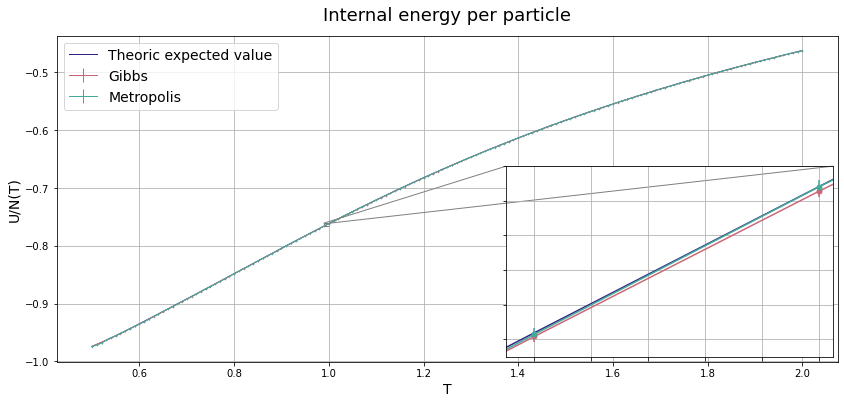

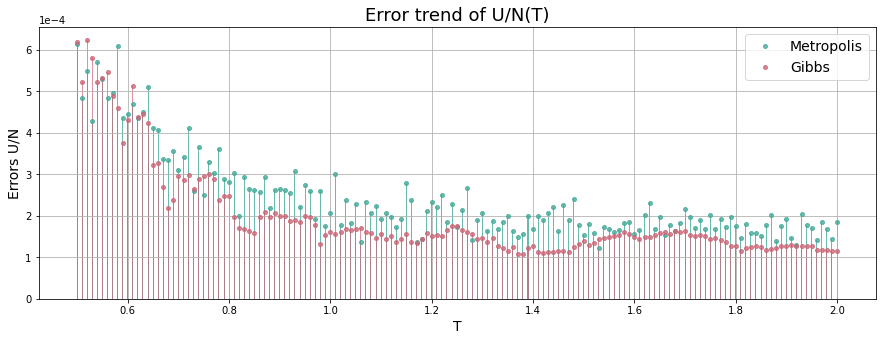

In [62]:
points=151
T = np.linspace(0.5,2.0,num=points)
beta = 1/T
J = 1.0
Ns = 50
th = np.tanh(J/T)
thN= th**Ns
ch = 1/th
e = -J*( th + ch*thN )/( 1 + thN )

fig, ax = plt.subplots(figsize=(14,6))
plt.title('Internal energy per particle', fontsize=18,pad=15)
plt.ticklabel_format(axis='both', style='sci',scilimits=(2,6))
plt.xlabel('T',fontsize=14)
plt.ylabel('U/N(T)',fontsize=14)
plt.grid(True)

#Zoom
x1, x2, y1, y2 = 0.989, 1.0005, -0.7665,-0.761
axins = zoomed_inset_axes(ax, zoom=60, loc=4)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax, axins, loc1=2, loc2=1, fc="none", ec="0.5")

#Grafico soluzione analitica
ax.plot(T, e, label='Theoric expected value',color = '#332288',alpha=1,linewidth=1)
axins.plot(T, e, color = '#332288',alpha=1)

temp, u_prog, errU_prog = ((np.genfromtxt('ene_0.0', usecols=i, autostrip=True)) for i in range(3))

#Gibbs
ax.errorbar(temp, u_prog, yerr=errU_prog, color= '#CC6677', alpha=1, marker='.',linewidth=1, markersize=1, label='Gibbs')
axins.errorbar(temp, u_prog,marker='.',color= '#CC6677', markersize=10, yerr=errU_prog)

temp, u_prog, errU_prog = ((np.genfromtxt('ene_1.0', usecols=i, autostrip=True)) for i in range(3))

#Metropolis
ax.errorbar(temp, u_prog, yerr=errU_prog, color='#44AA99', alpha=1, marker='.',linewidth=1, markersize=1, label='Metropolis')
axins.errorbar(temp, u_prog,marker='.', color='#44AA99', markersize=10, alpha=1, yerr=errU_prog)

ax.legend(loc=2,fontsize=14)

plt.grid(True)
plt.draw()
plt.show()

points=151
T = np.linspace(2.0,0.5,num=points)
beta = 1/T
J = 1.0
Ns = 50
th = np.tanh(J/T)
thN= th**Ns
ch = 1/th
e = -J*( th + ch*thN )/( 1 + thN )

plt.figure(figsize=(15,5))
plt.title('Error trend of U/N(T)',fontsize=18)
plt.plot(temp,errU_prog, marker='.',ls='', color='#44AA99', alpha=0.8, markersize=8, label='Metropolis')
plt.bar(temp,errU_prog,width=0.002, color='#44AA99', alpha=0.8)
temp, u_prog, errU_prog = ((np.genfromtxt('ene_0.0', usecols=i, autostrip=True)) for i in range(3))
plt.plot(temp,errU_prog, marker='.',ls='', color='#CC6677', alpha=0.8,markersize=8, label='Gibbs')
plt.bar(temp,errU_prog,width=0.002, color='#CC6677', alpha=0.7)
plt.legend(loc='upper right',fontsize=14)
plt.ticklabel_format(axis='both', style='sci',scilimits=(2,4))
plt.grid(True)
plt.xlabel('T',fontsize=14)
plt.ylabel('Errors U/N',fontsize=14)
plt.show()

Come possiamo vedere, le misure di $U/N$ risultanti dalle simulazioni sono concordi con l'andamento teorico in funzione della temperatura. Il contributo termico diminuisce per $T\rightarrow0$ e poiché il materiale è ferromagnetico, gli spin tendono ad allinearsi facendo sì che $U/N\rightarrow-1$.
Osserviamo inoltre il grafico relativo all'andamento degli errori per i due algoritmi in funzione della temperatura.
Per entrambi i metodi l'errore aumenta al diminuire della temperatura e questa è una prima prova di quanto viene detto a proposito delle difficoltà di campionamento a basse temperature.

**B) Capacità termica**:

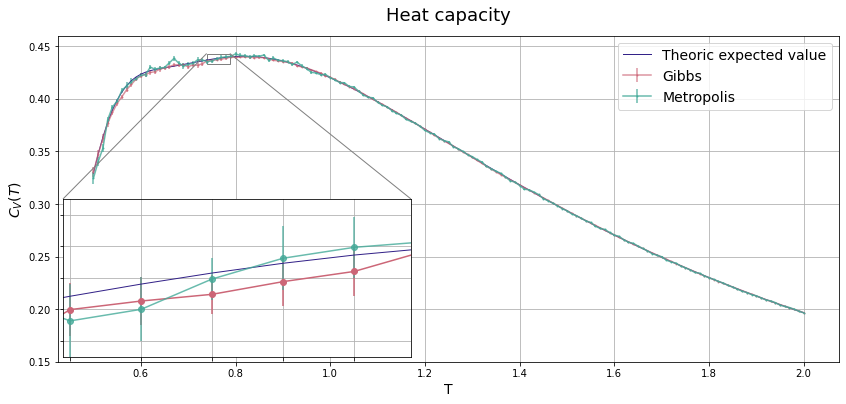

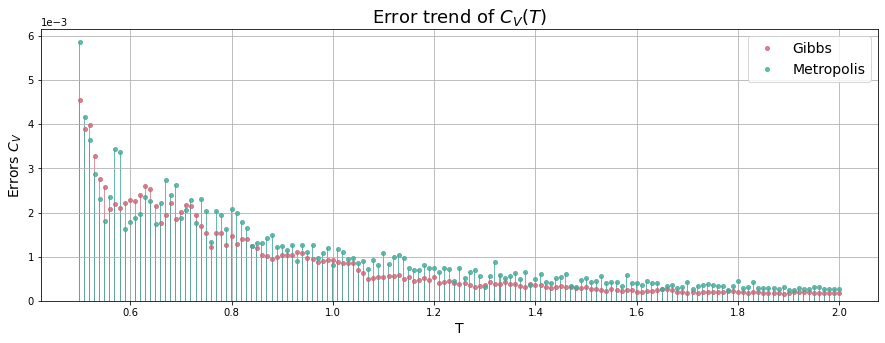

In [61]:
heat=((beta*J)**2)*(((1+thN+(Ns-1)*(th**2)+(Ns-1)*(ch**2)*thN)/(1+thN))-Ns*((th+ch*thN)/(1+thN))**2)

fig, ax = plt.subplots(figsize=(14,6))
plt.title('Heat capacity',fontsize=18,pad=15)
plt.xlabel('T',fontsize=14)
plt.ylabel(r'$ C_V(T) $',fontsize=14)
plt.ylim(0.15,0.46)
plt.grid(True)

#Zoom
x1, x2, y1, y2 = 0.739, 0.788, 0.433,0.443
axins = zoomed_inset_axes(ax, zoom=15, loc=3)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax, axins, loc1=2, loc2=1, fc="none", ec="0.5")

#Grafico soluzione analitica
ax.plot(T, heat, label='Theoric expected value' ,color = '#332288',alpha=1,linewidth=1)
axins.plot(T, heat,color = '#332288',alpha=1,linewidth=1)

temp, heat_prog, errheat_prog = ((np.genfromtxt('heat_0.0', usecols=i, autostrip=True)) for i in range(3))

#Gibbs
ax.errorbar(temp, heat_prog, yerr=errheat_prog, color = '#CC6677',alpha =0.7, marker='.', markersize=2, label='Gibbs')
axins.errorbar(temp, heat_prog,marker='.',color = '#CC6677', markersize=12, yerr=errheat_prog)

temp, heat_prog, errheat_prog = ((np.genfromtxt('heat_1.0', usecols=i, autostrip=True)) for i in range(3))

#Metropolis
ax.errorbar(temp, heat_prog, yerr=errheat_prog, color='#44AA99', alpha =0.8, marker='.', markersize=2, label='Metropolis')
axins.errorbar(temp, heat_prog, yerr=errheat_prog, marker='.', color='#44AA99', markersize=12,alpha =0.8)


ax.legend(loc=1,fontsize=14)

plt.grid(True)
plt.draw()
plt.show()

points=151
T = np.linspace(2.0,0.5,num=points)
beta = 1/T
J = 1.0
Ns = 50
th = np.tanh(J/T)
thN= th**Ns
ch = 1/th
e = -J*( th + ch*thN )/( 1 + thN )

plt.figure(figsize=(15,5))#np.abs(u_prog-e)
plt.title('Error trend of $C_V(T)$',fontsize=18)
temp, heat_prog, errheat_prog = ((np.genfromtxt('heat_0.0', usecols=i, autostrip=True)) for i in range(3))
plt.plot(temp,errheat_prog, marker='.',ls='', color='#CC6677', alpha=0.8,markersize=8, label='Gibbs')
plt.bar(temp,errheat_prog,width=0.002, color='#CC6677', alpha=0.7)
temp, heat_prog, errheat_prog = ((np.genfromtxt('heat_1.0', usecols=i, autostrip=True)) for i in range(3))
plt.plot(temp,errheat_prog, marker='.',ls='', color='#44AA99', alpha=0.8, markersize=8, label='Metropolis')
plt.bar(temp,errheat_prog,width=0.002, color='#44AA99', alpha=0.8)
plt.legend(loc='upper right',fontsize=14)
plt.ticklabel_format(axis='both', style='sci',scilimits=(2,4))
plt.grid(True)
plt.xlabel('T',fontsize=14)
plt.ylabel('Errors $C_V$',fontsize=14)
plt.show()

La capacità termica rappresenta la risposta in energia al variare della temperatura ed è determinabile come la misura delle fluttuazioni quadratiche dell'energia, o in altri termini come la varianza di $H$.
Come possiamo vedere dal grafico, essa presenta un massimo intorno a $T=0.8$ per poi decrescere repentinamente a sinistra dello stesso. Da un punto di vista fisico ciò significa che il sistema è in una situazione dove cerca di creare configurazioni ordinate di spin, per arrivare poi a $T=0$ dove il sistema effettivamente presenta ordine a lungo raggio.
Le misurazioni effettuate seguono l'andamento teorico.
Per quanto riguarda l'andamento degli errori in funzione della temperatura, valgono le stesse considerazioni del caso dell'energia.

**C) Suscettibilità**:

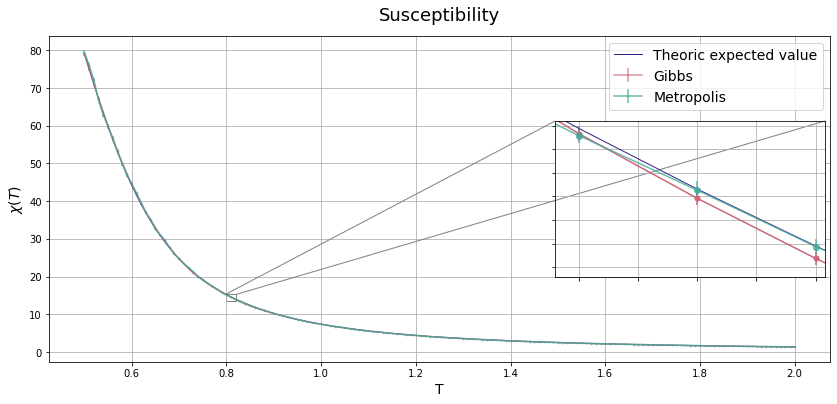

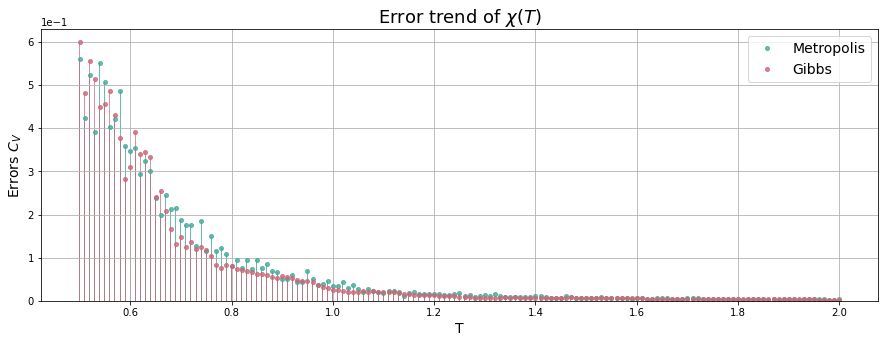

In [60]:
X = beta*np.exp(2*beta*J)*(1-thN)/(1+thN)

fig, ax = plt.subplots(figsize=(14,6))
plt.title('Susceptibility',fontsize=18,pad=15)
plt.xlabel('T',fontsize=14)
plt.ylabel('$\chi(T)$',fontsize=14)
plt.grid(True)

#Zoom 
x1, x2, y1, y2 = 0.798, 0.8208, 13.65, 15.3
axins = zoomed_inset_axes(ax, zoom=25, loc=5)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax, axins, loc1=2, loc2=1, fc="none", ec="0.5")

#Grafico soluzione analitica
ax.plot(T, X, label='Theoric expected value',color = '#332288',alpha=1,linewidth=1)
axins.plot(T, X,color = '#332288',alpha=1,linewidth=1)

temp, x_prog, errx_prog = ((np.genfromtxt('chi_0.0', usecols=i, autostrip=True)) for i in range(3))

#Gibbs
ax.errorbar(temp, x_prog, yerr=errx_prog, color='#CC6677', alpha =0.7, marker='.', markersize=1, label='Gibbs')
axins.errorbar(temp, x_prog,marker='.',color='#CC6677', markersize=10, yerr=errx_prog)

temp, chi_prog, errchi_prog = ((np.genfromtxt('chi_1.0', usecols=i, autostrip=True)) for i in range(3))

#Metropolis
ax.errorbar(temp, chi_prog, yerr=errchi_prog, color='#44AA99', alpha =0.8, marker='.', markersize=1, label='Metropolis')
axins.errorbar(temp, chi_prog, yerr=errchi_prog, marker='.', color='#44AA99', markersize=12,alpha =0.8)


ax.legend(loc=1,fontsize=14)

plt.grid(True)
plt.draw()
plt.show()

points=151
T = np.linspace(2.0,0.5,num=points)
beta = 1/T
J = 1.0
Ns = 50
th = np.tanh(J/T)
thN= th**Ns
ch = 1/th
e = -J*( th + ch*thN )/( 1 + thN )

plt.figure(figsize=(15,5))#np.abs(u_prog-e)
plt.title('Error trend of $\chi(T)$',fontsize=18)
temp, chi_prog, errchi_prog = ((np.genfromtxt('chi_1.0', usecols=i, autostrip=True)) for i in range(3))
plt.plot(temp,errchi_prog, marker='.',ls='', color='#44AA99', alpha=0.8, markersize=8, label='Metropolis')
plt.bar(temp,errchi_prog,width=0.002, color='#44AA99', alpha=0.8)
temp, chi_prog, errchi_prog = ((np.genfromtxt('chi_0.0', usecols=i, autostrip=True)) for i in range(3))
plt.plot(temp,errchi_prog, marker='.',ls='', color='#CC6677', alpha=0.8,markersize=8, label='Gibbs')
plt.bar(temp,errchi_prog,width=0.002, color='#CC6677', alpha=0.7)
plt.legend(loc='upper right',fontsize=14)
plt.ticklabel_format(axis='both', style='sci',scilimits=(2,4))
plt.grid(True)
plt.xlabel('T',fontsize=14)
plt.ylabel('Errors $C_V$',fontsize=14)
plt.show()

La sucettività magnetica rappresenta la risposta del sistema magnetico ad una variazione del campo esterno $h$ ed è determinabile come misura delle fluttuazioni quadratiche della magnetizzazione.
A basse $T$ la suscettività diventa molto alta poiché ad una perturbazione debole dovuta al campo esterno, il sistema risponde con una variazione di magnetizzazione enorme.
Come nei casi precedenti possiamo vedere come i dati della simulazione seguano l'andamento teorico aspettato. Per quanto riguarda l'andamento degli errori in funzione della temperatura, valgono considerazioni analoghe al caso dell'energia e della capacità termica.

**D) Magnetizzazione**:

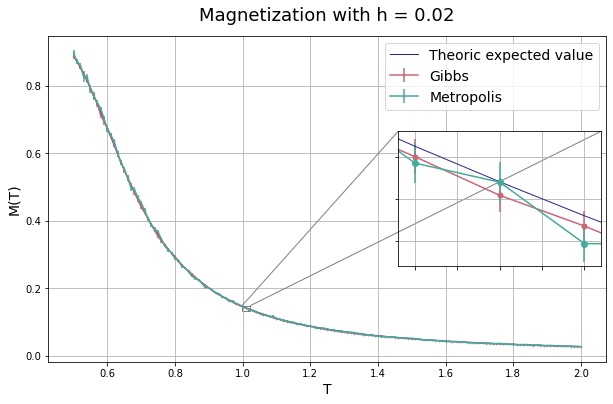

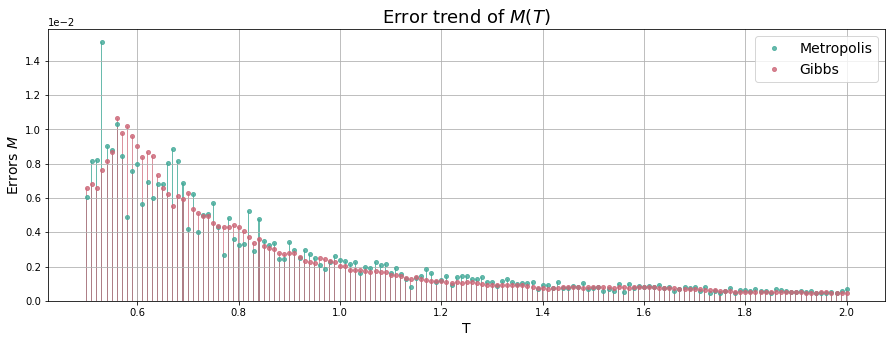

In [59]:
h=0.02 #external field
b = 1/T

l1 = np.exp(b*J)*np.cosh(b*h)+np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
l2 = np.exp(b*J)*np.cosh(b*h)-np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
Z = l1**Ns + l2**Ns
M = (np.exp(b*J)*np.sinh(b*h)*((l1**(Ns-1))*(1+np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))) 
        + (l2**(Ns-1))*(1-np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J)))))/(Z)


fig, ax = plt.subplots(figsize=(10,6))
plt.title('Magnetization with h = 0.02',fontsize=18,pad=15)
plt.xlabel('T',fontsize=14)
plt.ylabel('M(T)',fontsize=14)
plt.grid(True)

#Zoom 
x1, x2, y1, y2 = 0.998, 1.022, 0.132, 0.148
axins = zoomed_inset_axes(ax, zoom=25, loc=5)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax, axins, loc1=2, loc2=1, fc="none", ec="0.5")

#Grafico soluzione analitica
ax.plot(T, M, label='Theoric expected value',color = '#332288',alpha=1,linewidth=1)
axins.plot(T, M,color = '#332288',alpha=1,linewidth=1)

temp, m_prog, errm_prog = ((np.genfromtxt('m_0.0', usecols=i, autostrip=True)) for i in range(3))

#Gibbs
ax.errorbar(temp, m_prog, yerr=errm_prog, color='#CC6677', alpha =1, marker='.', markersize=1, label='Gibbs')
axins.errorbar(temp, m_prog,marker='.',color='#CC6677', markersize=10, yerr=errm_prog)

temp, m_prog, errm_prog = ((np.genfromtxt('m_1.0', usecols=i, autostrip=True)) for i in range(3))

#Metropolis
ax.errorbar(temp, m_prog, yerr=errm_prog, color='#44AA99', alpha=1, marker='.', markersize=1, label='Metropolis')
axins.errorbar(temp, m_prog, yerr=errm_prog, marker='.', color='#44AA99', markersize=12,alpha =1)


ax.legend(loc=1,fontsize=14)

plt.grid(True)
plt.draw()
plt.show()

plt.figure(figsize=(15,5))
plt.title('Error trend of $M(T)$',fontsize=18)
temp, m_prog, errm_prog = ((np.genfromtxt('m_1.0', usecols=i, autostrip=True)) for i in range(3))
plt.plot(temp,errm_prog, marker='.',ls='', color='#44AA99', alpha=0.8, markersize=8, label='Metropolis')
plt.bar(temp,errm_prog,width=0.002, color='#44AA99', alpha=0.8)
temp, m_prog, errm_prog = ((np.genfromtxt('m_0.0', usecols=i, autostrip=True)) for i in range(3))
plt.plot(temp,errm_prog, marker='.',ls='', color='#CC6677', alpha=0.8,markersize=8, label='Gibbs')
plt.bar(temp,errm_prog,width=0.002, color='#CC6677', alpha=0.7)
plt.legend(loc='upper right',fontsize=14)
plt.ticklabel_format(axis='both', style='sci',scilimits=(2,4))
plt.grid(True)
plt.xlabel('T',fontsize=14)
plt.ylabel('Errors $M$',fontsize=14)
plt.show()

La magnetizzazione man mano che il sistema perde agitazione termica e quindi si avvia verso una fase ordinata, tende a crescere, poiché il campo è orientato positivamente ($h=0.02$) lungo l'asse di orientazione degli spin.
Come possiamo vedere, anche in questo caso le misure effettuate seguono l'andamento teorico aspettato. 
Per quanto riguarda l'andamento degli errori in funzione della temperatura, l'errore si comporta come nei casi precedenti a meno della regione $T\lesssim0.55$. In questo caso infatti l'errore decresce al diminuire di $T$ e ciò potrebbe essere giustificato dalla coesistenza di due effetti. Da un lato le configurazioni sulle quali effettuare le misure diminuiscono e quindi ci si aspetta un'incertezza statistica crescente al diminuire di $T$. D'altra parte a temperature così basse è probabile che le configurazioni di spin siano molto simili tra loro e dunque ci si può aspettare una magnetizzazione molto stabile tra le diverse conformazioni. Questo secondo aspetto può contribuire a diminuire l'errore statistico.